#Importing libraries, modules

In [ ]:
# # Check libcudnn8 version
# !apt-cache policy libcudnn8

# # Install latest version
# !apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

# # Export env variables
# !export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
# !export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
# !export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
# !export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

# # Install tensorflow
# !pip install tflite-model-maker==0.4.0
# !pip uninstall -y tensorflow && pip install -q tensorflow==2.9.1
# !pip install pycocotools==2.0.4
# !pip install opencv-python-headless==4.6.0.66

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import pandas as pd
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.mobilenet import MobileNet
# from tensorflow.keras.applications import MobileNetV2 as MobileNet
#kita pake mobilenet yang dari dosen pembimbing
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
#import the library that we want to use
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
!pip install keras-metrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.optimizers import Adam

#Mount access to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#seed split data

sid=223
data_dirtrain='/content/drive/MyDrive/Kulitku Final/Train'
data_dirtest='/content/drive/MyDrive/Kulitku Final/Test'
data_dirvalid='/content/drive/MyDrive/Kulitku Final/Valid'

#Data Splitting to Training

In [ ]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dirtrain,
  # shuffle=True,
  seed=sid,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 799 files belonging to 4 classes.


#Data Splitting to Validation

In [ ]:
#split data ke validating
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dirtest,
  # shuffle=True,
  seed=sid,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 80 files belonging to 4 classes.


#Defining Class Name

In [ ]:
classnames = train_ds.class_names
print(classnames,"\n",len(classnames))

['Jerawat', 'Kutil', 'Melasma', 'Milia'] 
 4


#Showing The Dataset Image

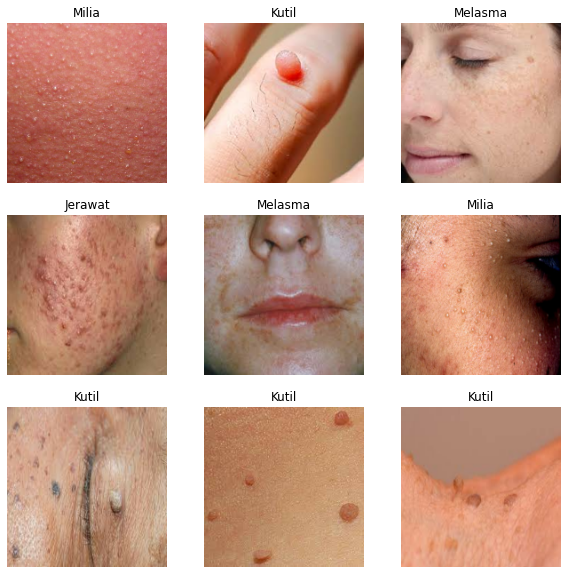

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classnames[labels[i]])
    plt.axis("off")

#Pre-Trained Model

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Flatten,Dropout
mobilenet_model = ''
mobilenet_model = Sequential()

pretrained_model= tf.keras.applications.MobileNet(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=4,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobilenet_model.add(pretrained_model)

#sama kaya diatas cuma dipisah MODELLLL

mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dropout(0.3))
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dropout(0.3))
mobilenet_model.add(Dense(4, activation='softmax'))

In [ ]:
mobilenet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                      

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

#Training The Model

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

In [ ]:
import keras
import keras_metrics
mobilenet_model.compile(optimizer=Adam(learning_rate=0.01),loss='SparseCategoricalCrossentropy',metrics=['accuracy',keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])
callbacks = myCallback()
import time
start_time=time.time()
history = mobilenet_model.fit(train_ds, validation_data=val_ds, epochs=15)
end_time=time.time()
waktu=round(end_time-start_time,2)
print('waktu:',waktu)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


25/25 [==============================] - ETA: 0s - loss: 4.4141 - accuracy: 0.3279 - precision: 1.6063 - recall: 0.1510 - f1_score: 0.2736

25/25 [==============================] - 7s 153ms/step - loss: 4.4141 - accuracy: 0.3279 - precision: 1.6063 - recall: 0.1510 - f1_score: 0.2736 - val_loss: 1.1782 - val_accuracy: 0.4250 - val_precision: 1.5087 - val_recall: 0.1103 - val_f1_score: 0.2056
Epoch 2/15
25/25 [==============================] - 3s 103ms/step - loss: 1.1438 - accuracy: 0.4793 - precision: 1.4608 - recall: 0.0935 - f1_score: 0.1757 - val_loss: 1.1126 - val_accuracy: 0.4875 - val_precision: 1.3554 - val_recall: 0.1000 - val_f1_score: 0.1863
Epoch 3/15
25/25 [==============================] - 3s 103ms/step - loss: 1.1106 - accuracy: 0.4931 - precision: 1.3219 - recall: 0.0943 - f1_score: 0.1760 - val_loss: 1.1787 - val_accuracy: 0.5125 - val_precision: 1.2941 - val_recall: 0.0841 - val_f1_score: 0.1579
Epoch 4/15
25/25 [==============================] - 3s 104ms/step - loss: 1.1038 - accuracy: 0.4543 - precision: 1.2709 - recall: 0.0776 - f1_score: 0.1462 - val_loss: 1.3740 - val_accuracy: 0.4625 - val_precision

#Model Evaluation

In [ ]:
print('akurasi:',history.history['accuracy'][-5:],'\n','precision:',history.history['precision'][-5:],'\n','Recall:',history.history['recall'][-5:],'\n','F1 score:',history.history['f1_score'][-5:])


akurasi: [0.5331664681434631, 0.5231539607048035, 0.5394243001937866, 0.5031288862228394, 0.525657057762146] 
 precision: [0.8892457485198975, 0.8372982144355774, 0.8069333434104919, 0.7707675099372864, 0.7477800846099854] 
 Recall: [0.0512864924967289, 0.050951603800058365, 0.04979770630598068, 0.04821734502911568, 0.04634172096848488] 
 F1 score: [0.09697889536619186, 0.09605756402015686, 0.09380587935447693, 0.09075700491666794, 0.0872747153043747]


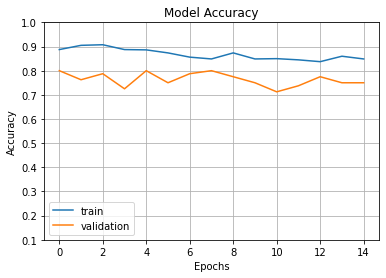

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
persenhasil,total=0,0

#Checking image quality

In [ ]:
import cv2
dircheck=data_dirtrain

from PIL import Image
import os, random
i=0
for classes in os.listdir(dircheck):
  persenhasil,total=0,0
  for i in range(200):
    pathcoba      = os.path.join(dircheck,classes)
    asalimg       = random.choice(os.listdir(pathcoba))
    asal_pilih    = os.path.join(pathcoba,asalimg)
    img           = cv2.imread(asal_pilih)
    image_resized = cv2.resize(img,(img_height,img_width))
    img           = np.expand_dims(image_resized,axis=0)
    pred          = resnet_model.predict(img)
    output_class  = classnames[np.argmax(pred)]
    if (i%50==0):
      print("image "+ str(i)+" ",asalimg,"The predicted class for",classes," is",output_class + " and it is",output_class==classes)

    if(output_class==classes):
      persenhasil+=1
      total+=1
    else :
      total+=1
  print('\033[1m'+"persentase total",classes, (persenhasil/total)*100,"%"+'\033[0m')

image 0  Milia84.jpg The predicted class for Milia  is Milia and it is True
image 50  Milia179.jpg The predicted class for Milia  is Milia and it is True
image 100  Milia204.jpg The predicted class for Milia  is Milia and it is True
image 150  Milia72.jpg The predicted class for Milia  is Milia and it is True
persentase total Milia 99.0 %
image 0  download (32).jpeg The predicted class for Kutil  is Kutil and it is True
image 50  download (31).jpeg The predicted class for Kutil  is Kutil and it is True
image 100  images (37) copy.jpeg The predicted class for Kutil  is Milia and it is False
image 150  download (13).jpeg The predicted class for Kutil  is Kutil and it is True
persentase total Kutil 76.0 %
image 0  5e99287385ef981b117456d5_womans face with melasma on cheek copy 2.jpeg The predicted class for Melasma  is Melasma and it is True
image 50  images (2) copy.jpeg The predicted class for Melasma  is Melasma and it is True
image 100  HelloIMG1654444644658 copy.jpeg The predicted cl

#Importing Model

In [ ]:
resnet_model.save('./model with melasma paling baru terverifikasi.h5', save_format='h5')
# loading the saved model

In [ ]:
!mkdir -p saved_model
resnet_model.save('saved_model/model with melasma paling baru terverifikasi')

In [ ]:
import shutil
dir_to_zip = '/content/saved_model/model with melasma paling baru terverifikasi'
output_filename = 'model with melasma mantap'
shutil.make_archive(output_filename, 'zip', dir_to_zip)

'/content/model with melasma mantap.zip'

# SVM


In [ ]:
import numpy as np
import os 
from pathlib import Path
from keras.preprocessing import image

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
p = Path(data_dirtrain)
dirs = p.glob("*")

labels_dict = {"Milia":0,"Kutil":1,"Melasma":2,"Jerawat":3}

image_data = []
labels = []
milia,kutil,melasma,jerawat=0,0,0,0
for folder_dir in dirs:
    # print(folder_dir)
    label = str(folder_dir).split("/")[-1][:20]
    # print(label)
    
    
    for img_path in folder_dir.glob("*"):
        # print(img_path)
        img = image.load_img(img_path,target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        # print(label)
        if label=='Milia':
          milia=milia+1
        if label=='Kutil':
          kutil=kutil+1
        if label=='Melasma':
          melasma=melasma+1
        if label=='Jerawat':
          jerawat=jerawat+1
        labels.append(labels_dict[label])
print('Milia :',milia,'\nKutil :',kutil,'\nmelasma :',melasma,'\njerawat :',jerawat)

Milia : 200 
Kutil : 199 
melasma : 200 
jerawat : 200


In [ ]:
# Convert this into numpy array
image_data = np.array(image_data,dtype='float32')/255.0
labels = np.array(labels)

print(image_data.shape,labels.shape)

(799, 32, 32, 3) (799,)


In [ ]:
import random

combined = list(zip(image_data,labels))
random.shuffle(combined)

#Unzip
image_data[:],labels[:] = zip(*combined)

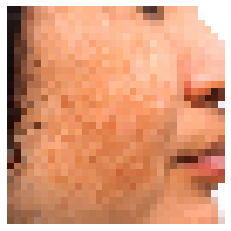

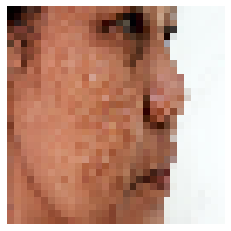

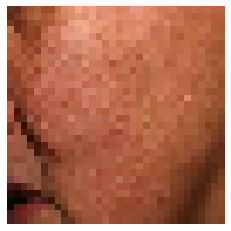

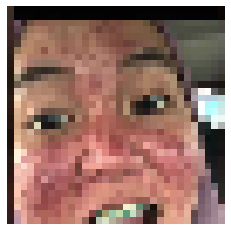

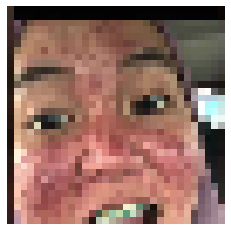

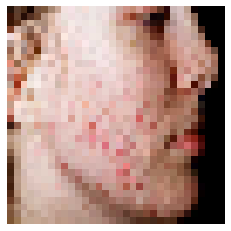

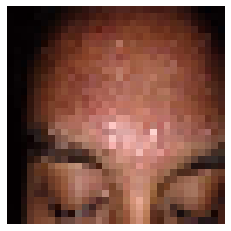

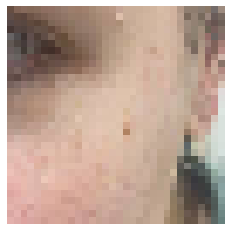

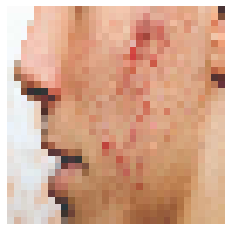

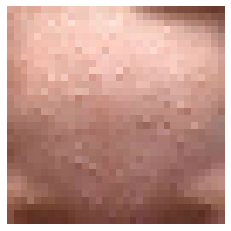

In [ ]:
from matplotlib import pyplot as plt

def drawImg(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()    
    return 

for i in range(10):
    drawImg(image_data[i])

In [ ]:
class SVM:
    """SVM Class, Author : Prateek Narang"""
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #Initial Loss
        
        #Training from here...
        # Weight and Bias update rule that we discussed!
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses

In [ ]:
M = image_data.shape[0] 
image_data = image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)

(799, 3072)
(799,)


In [ ]:
CLASSES = len(np.unique(labels))
print(CLASSES)

4


In [ ]:
#@title
def classWiseData(x,y):
    data = {}
    
    for i in range(CLASSES):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
    
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [ ]:
#@title
data = classWiseData(image_data,labels)

In [ ]:
#@title
def getDataPairForSVM(d1,d2):
    """Combines Data of two classes into a signle matrix"""
    
    l1,l2 = d1.shape[0],d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = +1
    
    return data_pair,data_labels
    

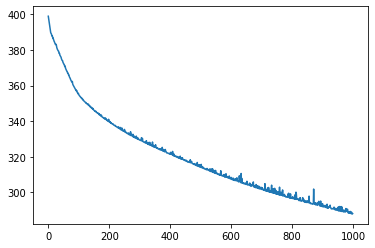

In [ ]:
#@title
mySVM  = SVM()
xp, yp  = getDataPairForSVM(data[0],data[1])
w,b,loss  = mySVM.fit(xp,yp,learning_rate=0.00001,maxItr=1000)
#print(loss)
plt.plot(loss)

In [ ]:
#@title
def trainSVMs(x,y):
    
    svm_classifiers = {}
    for i in range(CLASSES):
        svm_classifiers[i] = {}
        for j in range(i+1,CLASSES):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair,ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b)
            
            plt.plot(loss)
            plt.show()
            
    
    return svm_classifiers

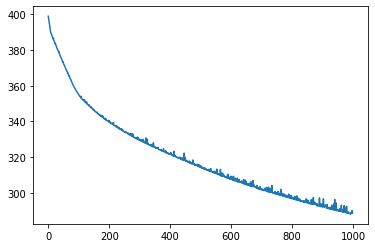

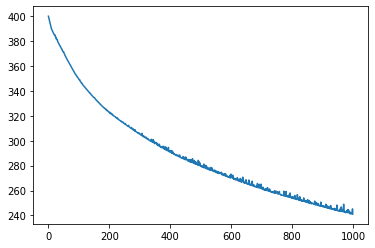

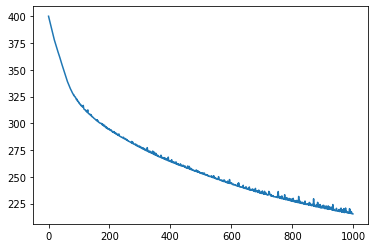

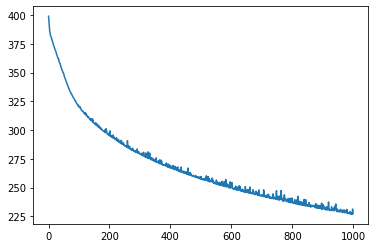

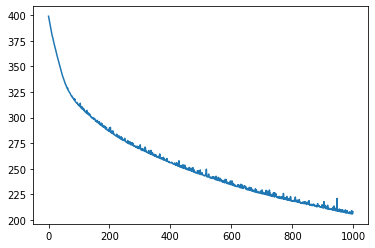

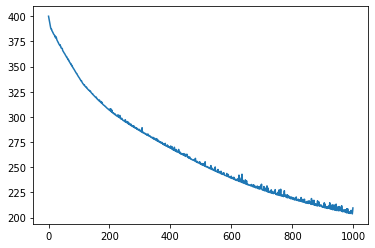

In [ ]:
#@title

svm_classifiers = trainSVMs(image_data,labels)

In [ ]:
#@title
#Parameters for Cats and dogs
cats_dogs = svm_classifiers[0][1]
cats_humans = svm_classifiers[0][3]
print(cats_dogs[0].shape)
print(cats_dogs[1])

(1, 3072)
-0.039540000000000054


In [ ]:
#@title
def binaryPredict(x,w,b):
    z  = np.dot(x,w.T) + b
    if z>=0:
        return 1
    else:
        return -1

In [ ]:
#@title
def predict(x):
    
    count = np.zeros((CLASSES,))
    
    for i in range(CLASSES):
        for j in range(i+1,CLASSES):
            w,b = svm_classifiers[i][j]
            #Take a majority prediction 
            z = binaryPredict(x,w,b)
            
            if(z==1):
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    #print(count)
    return final_prediction

In [ ]:
print(predict(image_data[0]))
print(labels[0])

NameError: ignored

In [ ]:
def accuracy(x,y):
    
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction==y[i]):
            count += 1
            
    return count/x.shape[0]

In [ ]:
accuracy(image_data,labels)

---

In [ ]:
for folder_dir in dirs:
    # print(folder_dir)
    label = str(folder_dir).split("/")[-1][:20]
    print(label)
    
    
    for img_path in folder_dir.glob("*"):
        print(img_path)
        img = image.load_img(img_path,target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        print(label)
        labels.append(labels_dict[label])
        y_true.append(labels_dict[label])

In [ ]:
from sklearn import svm
import time
start_time=time.time()
svm_classifier = svm.SVC(kernel='linear',C=1.0,verbose=True)
svm_classifier.fit(image_data,labels)
end_time=time.time()
waktu=round(end_time-start_time,2)
print(waktu)
svm_classifier.score(image_data,labels)
p = Path(data_dirtest)
dirs = p.glob("*")

labels_dict = {"Milia":0,"Kutil":1,"Melasma":2,"Jerawat":3}
milia,kutil,melasma,jerawat=0,0,0,0
image_data = []
labels = []
y_true= []
for folder_dir in dirs:
    # print(folder_dir)
    label = str(folder_dir).split("/")[-1][:20]
    # print(label)
    
    
    for img_path in folder_dir.glob("*"):
        # print(img_path)
        img = image.load_img(img_path,target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        # print(label)
        labels.append(labels_dict[label])
        y_true.append(labels_dict[label])
        if label==0:
          milia+1
        if label==1:
          kutil+1
        if label==2:
          melasma+1
        if label==3:
          jerawat+1
image_data = np.array(image_data,dtype='float32')/255.0
labels = np.array(labels)

# print(image_data.shape,labels.shape)
M = image_data.shape[0] 
image_data = image_data.reshape(M,-1)
# print(image_data.shape)
# print(labels.shape)
y_pred= svm_classifier.predict(image_data)
y_pred
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
# y_true = np.array(['cat', 'dog', 'pig', 'cat', 'dog', 'pig'])
l=precision_recall_fscore_support(y_true, y_pred, average='macro')
print("SVM")
print("precision \t:"+ str(l[0]))
print("recall \t\t:"+ str(l[1]))
print("f1 score \t:"+ str(l[2]))
print("accuracy \t:"+str(accuracy_score(y_true,y_pred)))

[LibSVM]0.04
SVM
precision 	:1.0
recall 		:1.0
f1 score 	:1.0
accuracy 	:1.0


In [ ]:
from sklearn import svm
svm_classifier=''
svm_classifier = svm.SVC(kernel='poly',C=1.0)
svm_classifier.fit(image_data,labels)
svm_classifier.score(image_data,labels)
p = Path(data_dirtest)
dirs = p.glob("*")

labels_dict = {"Milia":0,"Kutil":1,"Melasma":2,"Jerawat":3}

image_data = []
labels = []
y_true= []
for folder_dir in dirs:
    # print(folder_dir)
    label = str(folder_dir).split("/")[-1][:20]
    print(label)
    
    
    for img_path in folder_dir.glob("*"):
        print(img_path)
        img = image.load_img(img_path,target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        print(label)
        labels.append(labels_dict[label])
        y_true.append(labels_dict[label])
image_data = np.array(image_data,dtype='float32')/255.0
labels = np.array(labels)

print(image_data.shape,labels.shape)
M = image_data.shape[0] 
image_data = image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)
y_pred= svm_classifier.predict(image_data)
y_pred
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
# y_true = np.array(['cat', 'dog', 'pig', 'cat', 'dog', 'pig'])
l=precision_recall_fscore_support(y_true, y_pred, average='macro')
print("SVM")
print("precision \t:"+ str(l[0]))
print("recall \t\t:"+ str(l[1]))
print("f1 score \t:"+ str(l[2]))
print("accuracy \t:"+str(accuracy_score(y_true,y_pred)))

Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia161.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia256.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia245.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia14.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia125.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia82.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia20.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia41.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia177.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia46.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia50.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia54.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia74.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia85.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia88.jpg
Milia

In [ ]:
from sklearn import svm
svm_classifier = svm.SVC(kernel='sigmoid',C=1.0)
svm_classifier.fit(image_data,labels)
svm_classifier.score(image_data,labels)
p = Path(data_dirtest)
dirs = p.glob("*")

labels_dict = {"Milia":0,"Kutil":1,"Melasma":2,"Jerawat":3}

image_data = []
labels = []
y_true= []
for folder_dir in dirs:
    # print(folder_dir)
    label = str(folder_dir).split("/")[-1][:20]
    print(label)
    
    
    for img_path in folder_dir.glob("*"):
        print(img_path)
        img = image.load_img(img_path,target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        print(label)
        labels.append(labels_dict[label])
        y_true.append(labels_dict[label])
image_data = np.array(image_data,dtype='float32')/255.0
labels = np.array(labels)

print(image_data.shape,labels.shape)
M = image_data.shape[0] 
image_data = image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)
y_pred= svm_classifier.predict(image_data)
y_pred
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
# y_true = np.array(['cat', 'dog', 'pig', 'cat', 'dog', 'pig'])
l=precision_recall_fscore_support(y_true, y_pred, average='macro')
print("SVM")
print("precision \t:"+ str(l[0]))
print("recall \t\t:"+ str(l[1]))
print("f1 score \t:"+ str(l[2]))
print("accuracy \t:"+str(accuracy_score(y_true,y_pred)))

Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia161.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia256.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia245.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia14.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia125.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia82.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia20.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia41.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia177.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia46.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia50.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia54.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia74.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia85.jpg
Milia
/content/drive/MyDrive/Kulitku Final/Test/Milia/Milia88.jpg
Milia

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# KNN

In [ ]:
 #Class to load the dataset images from drivce
import os
import cv2
import numpy as np


class SimpleDatasetLoader:
    # Method: Constructor
    def __init__(self, preprocessors=None):
        """
        :param preprocessors: List of image preprocessors
        """
        self.preprocessors = preprocessors

        if self.preprocessors is None:
            self.preprocessors = []

    # Method: Used to load a list of images for pre-processing
    def load(self, image_paths, verbose=-1):
        """
        :param image_paths: List of image paths
        :param verbose: Parameter for printing information to console
        :return: Tuple of data and labels
        """
        data, labels = [], []

        for i, image_path in enumerate(image_paths):
            image = cv2.imread(image_path)
            label = image_path.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)

            data.append(image)
            labels.append(label)

            if verbose > 0 and i > 0 and (i+1) % verbose == 0:
                print('[INFO]: Processed {}/{}'.format(i+1, len(image_paths)))

        return (np.array(data), np.array(labels))

In [ ]:
#Class Preprocessror 
class SimplePreprocessor:
    # Method: Constructor
    def __init__(self, width, height, interpolation=cv2.INTER_AREA):
        """
        :param width: Image width
        :param height: Image height
        :param interpolation: Interpolation algorithm
        """
        self.width = width
        self.height = height
        self.interpolation = interpolation

    # Method: Used to resize the image to a fixed size (ignoring the aspect ratio)
    def preprocess(self, image):
        """
        :param image: Image
        :return: Re-sized image
        """
        return cv2.resize(image, (self.width, self.height), interpolation=self.interpolation)

In [ ]:
#algorithm='ball_tree'
 #its fs
  
from imutils import paths
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from __main__ import SimplePreprocessor
from __main__ import SimpleDatasetLoader
import os
import cv2
import numpy as np



# Get list of image paths
image_paths = list(paths.list_images(data_dirtrain))

# Initialize SimplePreprocessor and SimpleDatasetLoader and load data and labels
print('[INFO]: Images loading....')
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data, labels) = sdl.load(image_paths, verbose=500)

# Reshape from (3000, 32, 32, 3) to (3000, 32*32*3=3072)
data = data.reshape((data.shape[0], 3072))

# Print information about memory consumption
print('[INFO]: Features Matrix: {:.1f}MB'.format(float(data.nbytes / 1024*1000.0)))

# Encode labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split data into training (75%) and testing (25%) data
(train_x, test_x, train_y, test_y) = train_test_split(data, labels, test_size=0.25, random_state=42)

# Train and evaluate the k-NN classifier on the raw pixel intensities
print('[INFO]: Classification starting....')
model = KNeighborsClassifier(n_neighbors=3,
                             n_jobs=1,algorithm='kd_tree')
import time
start_time=time.time()
model.fit(train_x, train_y)
end_time=time.time()
waktu=round(end_time-start_time,2)
print(waktu)
print(classification_report(test_y, model.predict(test_x),
                            target_names=le.classes_))

[INFO]: Images loading....
[INFO]: Processed 500/799
[INFO]: Features Matrix: 2397000.0MB
[INFO]: Classification starting....
0.11
              precision    recall  f1-score   support

     Jerawat       0.81      0.60      0.69        57
       Kutil       0.62      0.85      0.71        53
     Melasma       0.67      0.49      0.56        45
       Milia       0.56      0.64      0.60        45

    accuracy                           0.65       200
   macro avg       0.66      0.64      0.64       200
weighted avg       0.67      0.65      0.65       200

